In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import f_decline
from MaaSSim.utils import load_G, get_config

In [4]:
# https://github.com/uber/h3-py-notebooks/tree/master/notebooks
import h3
import folium
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
lat, lng = 37.769377, -122.388903
resolution = 8
h3_address = h3.geo_to_h3(lat, lng, resolution)
h3_address

'88283082e7fffff'

In [6]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 9) # lat, lng, hex resolution                                                                                                        
hex_center_coordinates = h3.h3_to_geo(h3_address)
hex_center_coordinates

(37.36267258237806, -122.05443585718207)

In [7]:
def visualize_hexagons(hexagons, color="red", w=1, folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=w,color=color,fill= True)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [8]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 8) # lat, lng, hex resolution                                                                                                        
m = visualize_hexagons([h3_address])
display(m)

In [9]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 9) # lat, lng, hex resolution                                                                                                        
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]                                                                                                                  
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[3]), color="purple")
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[1]), color="green", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[0]), color = "red", folium_map=m)


list(h3.k_ring(h3_address,1))

display(m)

In [10]:
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
df311 = pd.read_csv(noise_311_link)
df311

lat        lng
0      40.744989 -73.924964
1      40.590929 -74.072404
2      40.728413 -73.994252
3      40.603440 -74.011571
4      40.737613 -74.002905
...          ...        ...
99995  40.709723 -73.828881
99996  40.821107 -73.935743
99997  40.623986 -74.033779
99998  40.634456 -74.027728
99999  40.771206 -73.924613

[100000 rows x 2 columns]

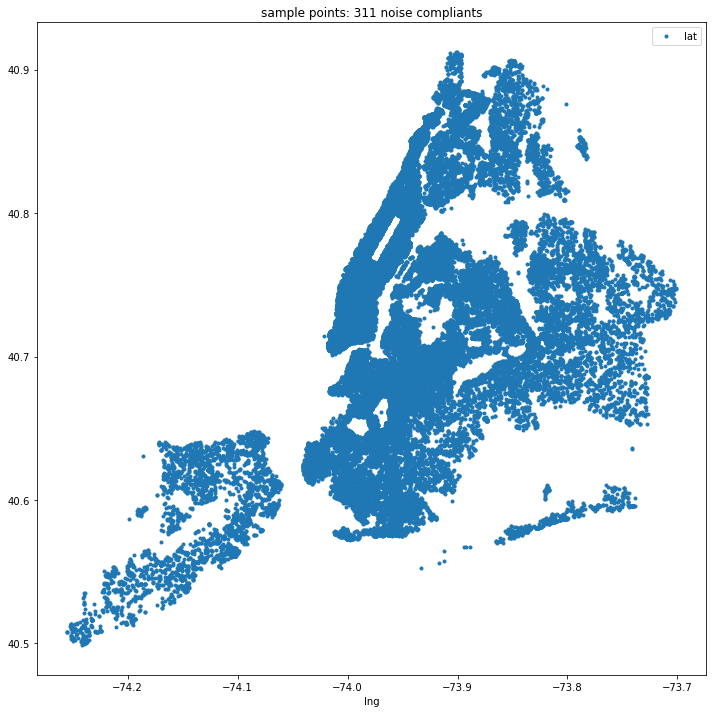

In [11]:
# Visualize the 311 noise complaints points
df311.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('sample points: 311 noise compliants');

In [12]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

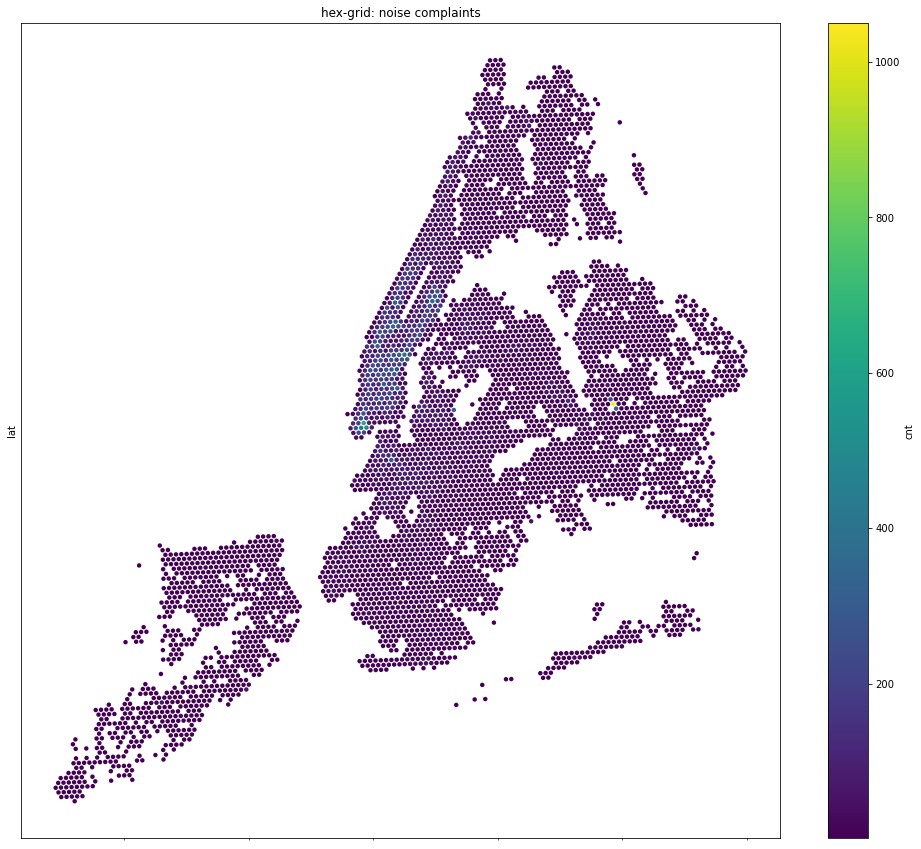

In [13]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o',figsize=(17,15))
plt.title('hex-grid: noise complaints');

In [14]:
l = list(df311g[hex_col])
m = visualize_hexagons(l)
display(m)

<AxesSubplot:xlabel='lng', ylabel='lat'>

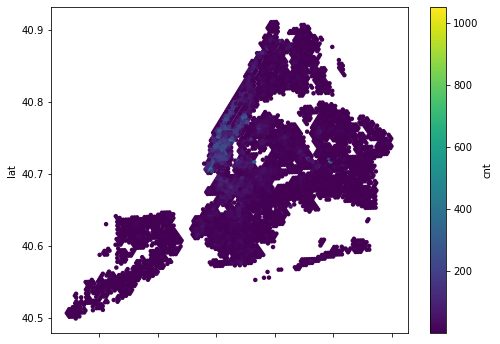

In [15]:
df = df311g
df.plot.scatter(x='lng', y='lat', c='cnt', edgecolors='none', colormap='viridis', marker='o', alpha=1, figsize=(8,6))

sum sanity check: 1.0


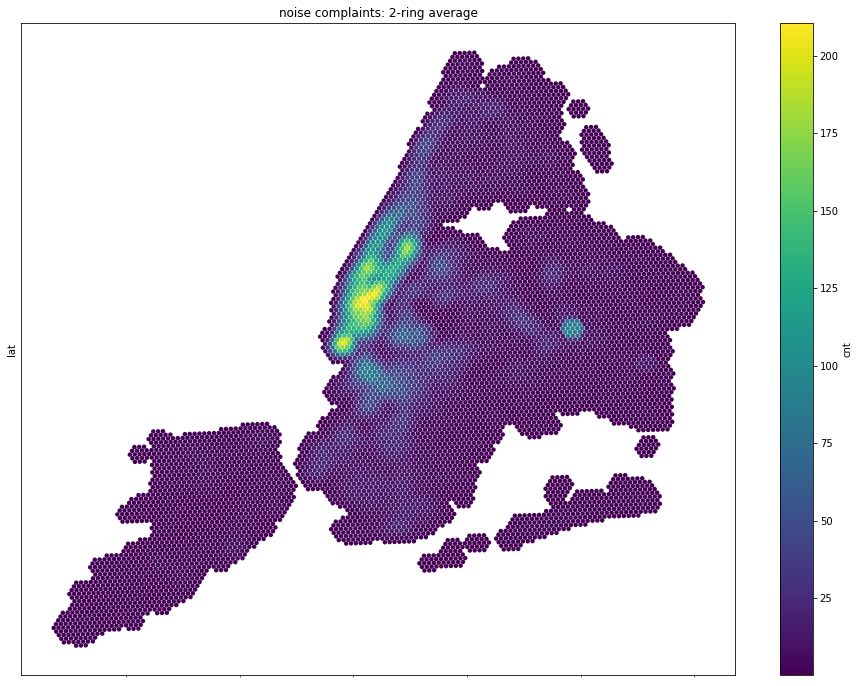

In [16]:
#kring_smoothing
k = 2
df311s= kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o')
plt.title('noise complaints: 2-ring average');

In [17]:
APERTURE_SIZE = 5
hex_col = 'hex'

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

l = list(df311g.hex)
m = visualize_hexagons(l, color='blue')
display(m)

<AxesSubplot:>

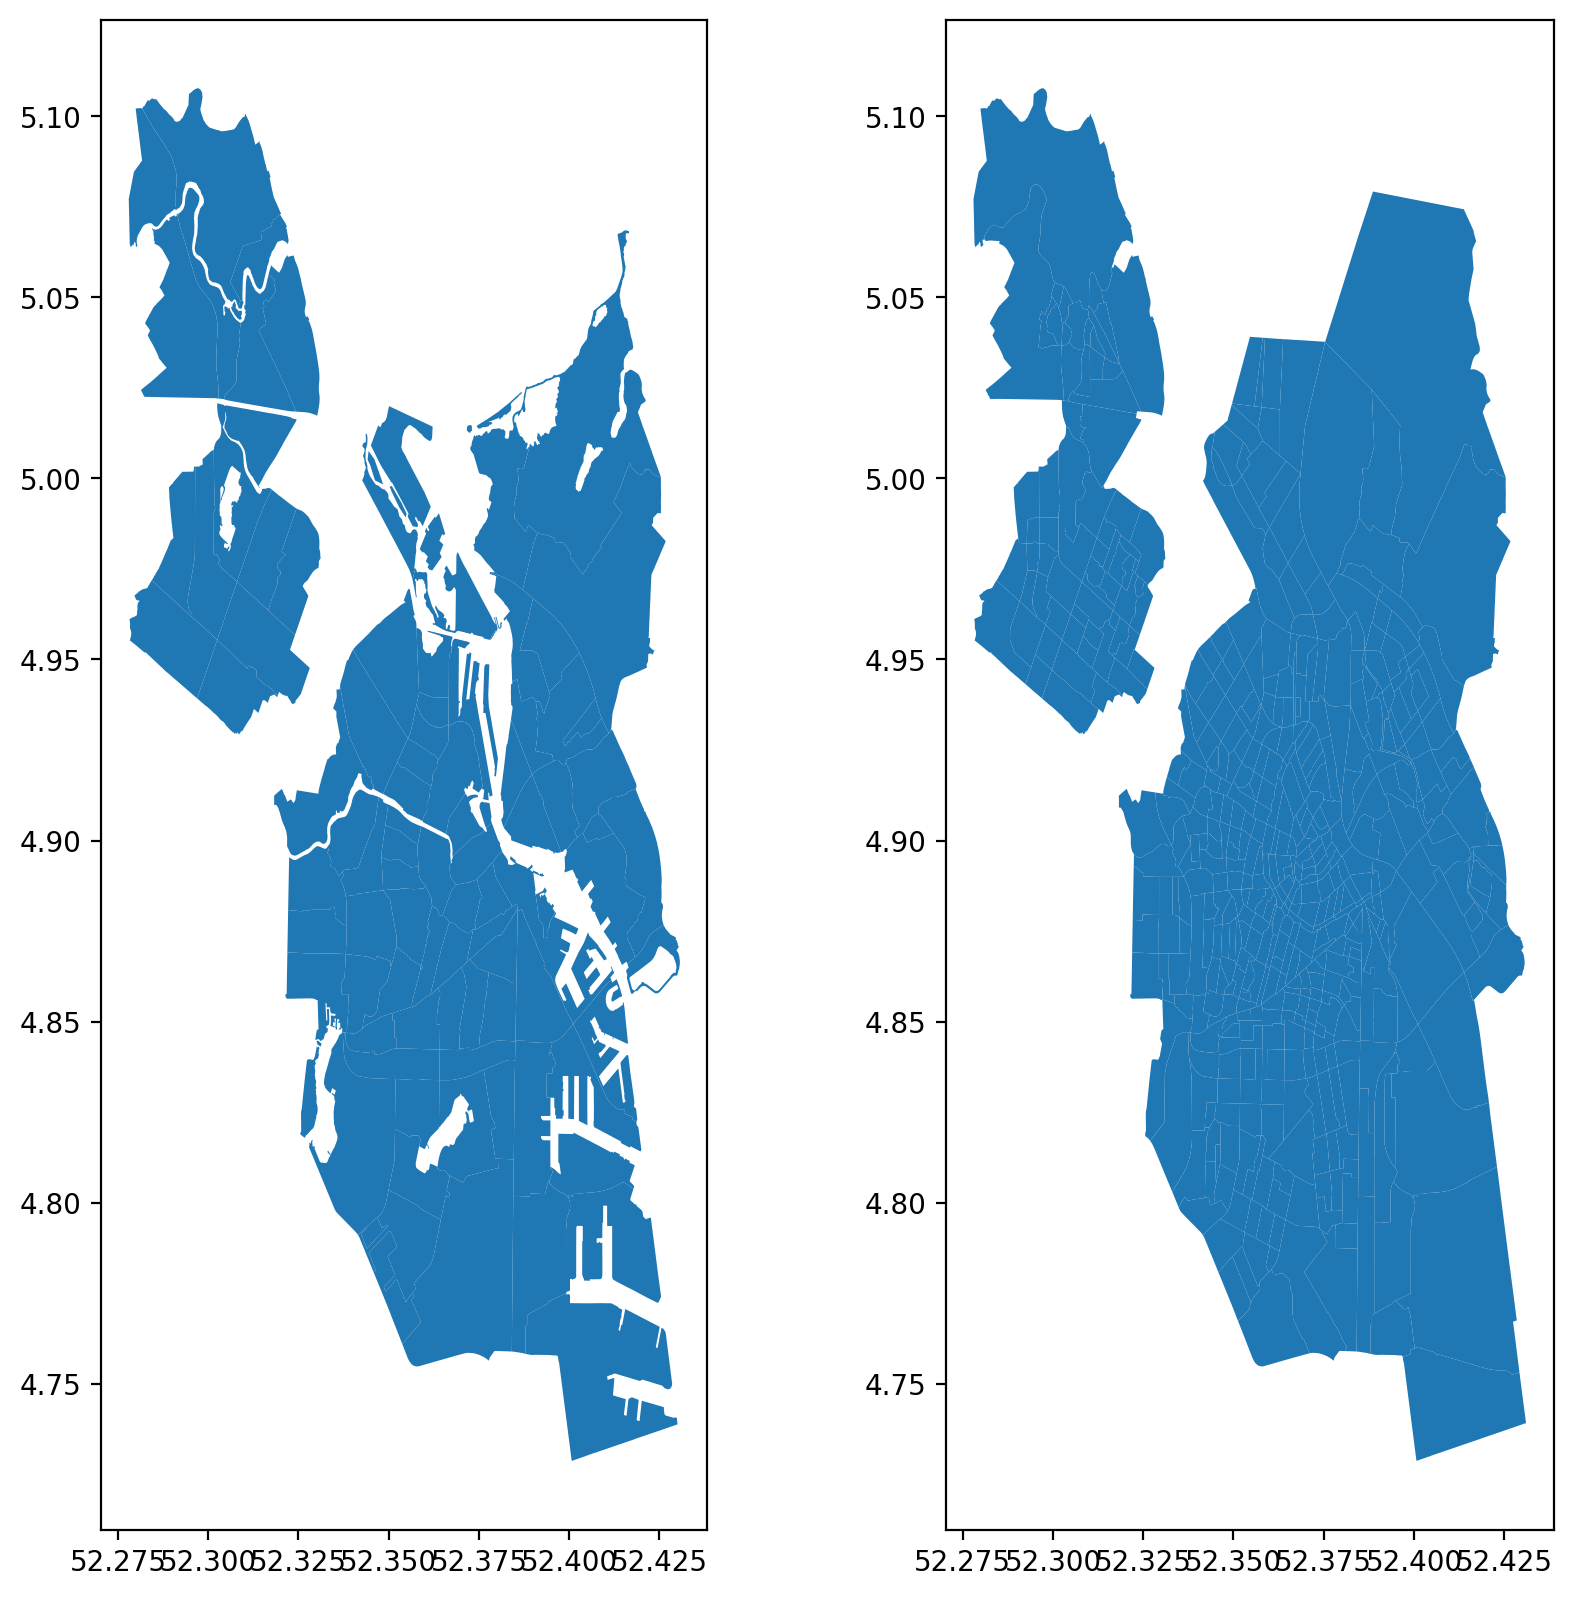

In [19]:
import geopandas as gpd
fig, ax = plt.subplots(dpi=200 ,nrows=1, ncols=2, figsize=(10,10))

df = gpd.read_file('https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=PC4_BUURTEN_EXWATER&THEMA=postcode')
df.plot(ax = ax[0])

df1 = gpd.read_file('https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=GEBIED_BUURTEN&THEMA=gebiedsindeling')
df1.plot(ax = ax[1])

In [ ]:
=Amsterdam==================================================================================================

In [10]:
paths= "../../data/graphs/Amsterdam.graphml"
G = ox.load_graphml(paths)

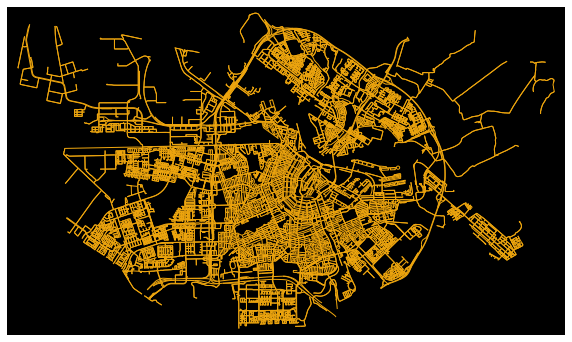

In [11]:
fig, ax = ox.plot_graph(G, figsize=(10, 10), show=False, close=False, node_size=0, bgcolor='black', 
                        edge_color=(0.933, 0.65, 0.059))

In [12]:
df = pd.read_csv('max_ds_100.csv')

df['lat'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[0])
df['lng'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[1])

l = list(df['hex_address'])
m = visualize_hexagons(l)
display(m)
# plot_scatter(df, metric_col='ave_max', marker='o',figsize=(17,15))

In [16]:
import json
from geojson.feature import Feature, FeatureCollection

params = get_config('glance.json')
params.params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"

inData = load_G(inData, params)  # load network graph 

In [108]:
df

hex_address  sim1  sim2  sim3  sim4  sim5  ave_max        lat  \
0   871968240ffffff   0.0   0.0   1.0   0.0   1.0      0.4  52.407115   
1   871968241ffffff   2.0   3.0   3.0   3.0   2.0      2.6  52.392750   
2   871968244ffffff   2.0   2.0   2.0   2.0   1.0      1.8  52.426069   
3   871968245ffffff   1.0   1.0   1.0   1.0   1.0      1.0  52.411706   
4   871968248ffffff   2.0   2.0   1.0   1.0   2.0      1.6  52.359413   
5   871968249ffffff   3.0   4.0   4.0   3.0   4.0      3.6  52.345029   
6   87196824cffffff   2.0   2.0   2.0   3.0   2.0      2.2  52.378377   
7   87196824dffffff   6.0   5.0   6.0   5.0   6.0      5.6  52.363995   
8   871968263ffffff   0.0   0.0   0.0   0.0   0.0      0.0  52.430657   
9   871968268ffffff   1.0   1.0   2.0   2.0   2.0      1.6  52.401912   
10  871968269ffffff   7.0   7.0   8.0   7.0   7.0      7.2  52.387527   
11  87196826affffff   1.0   2.0   2.0   2.0   1.0      1.6  52.397335   
12  87196826bffffff   7.0   7.0   8.0   7.0   6.0      7.0  52.382956   
13  87196826cffffff   1.0   1.0   2.0   2.0   1.0      1.4  52.420862   
14  87196826dffffff   4.0   2.0   3.0   3.0   3.0      3.0  52.406479   
15  87196826effffff   1.0   1.0   1.0   0.0   0.0      0.6  52.416289   
16  871969504ffffff   6.0   5.0   7.0   4.0   6.0      5.6  52.325355   
17  871969506ffffff   3.0   4.0   3.0   3.0   3.0      3.2  52.320800   
18  871969514ffffff   2.0   3.0   2.0   2.0   2.0      2.2  52.330637   
19  871969520ffffff   7.0   7.0   5.0   6.0   9.0      6.8  52.348864   
20  871969521ffffff   5.0   7.0   4.0   5.0   6.0      5.4  52.334440   
21  871969522ffffff  10.0   9.0  11.0   9.0  13.0     10.4  52.344321   
22  871969523ffffff   4.0   3.0   3.0   4.0   3.0      3.4  52.329902   
23  871969524ffffff   8.0   8.0   7.0   7.0  11.0      8.2  52.367822   
24  871969525ffffff   5.0   5.0   5.0   5.0   5.0      5.0  52.353399   
25  871969526ffffff  13.0  12.0  13.0  14.0  12.0     12.8  52.363281   
26  871969530ffffff  13.0  10.0  11.0   9.0  10.0     10.6  52.354172   
27  871969531ffffff   9.0   8.0   6.0   6.0   8.0      7.4  52.339768   
28  871969532ffffff   9.0   8.0   8.0   9.0   8.0      8.4  52.349605   
29  871969533ffffff   3.0   3.0   3.0   5.0   3.0      3.4  52.335207   
30  871969534ffffff  11.0  14.0  12.0  13.0  12.0     12.4  52.373133   
31  871969535ffffff  13.0  13.0  11.0  11.0  15.0     12.6  52.358731   
32  871969536ffffff   9.0   8.0  10.0   7.0   8.0      8.4  52.368568   
33  871969c81ffffff   0.0   0.0   0.0   0.0   1.0      0.2  52.424663   
34  871969c83ffffff   2.0   3.0   2.0   2.0   3.0      2.4  52.420130   
35  871969c88ffffff   1.0   2.0   1.0   1.0   1.0      1.2  52.391304   
36  871969c89ffffff   1.0   1.0   1.0   1.0   1.0      1.0  52.376878   
37  871969c8affffff   6.0   5.0   4.0   5.0   5.0      5.0  52.386774   
38  871969c8bffffff   2.0   3.0   2.0   2.0   2.0      2.2  52.372354   
39  871969c8cffffff   1.0   1.0   1.0   1.0   1.0      1.0  52.410248   
40  871969c8dffffff   1.0   1.0   1.0   1.0   1.0      1.0  52.395825   
41  871969c8effffff   0.0   1.0   1.0   1.0   1.0      0.8  52.405721   
42  871969c91ffffff   4.0   3.0   3.0   4.0   3.0      3.4  52.429984   
43  871969c93ffffff   2.0   2.0   2.0   2.0   2.0      2.0  52.425427   
44  871969c98ffffff   6.0   6.0   5.0   8.0   5.0      6.0  52.396641   
45  871969c99ffffff   6.0   6.0   5.0   5.0   6.0      5.6  52.382236   
46  871969c9affffff   6.0   7.0   9.0   8.0   9.0      7.8  52.392088   
47  871969c9bffffff  14.0  14.0  12.0  14.0  13.0     13.4  52.377689   
48  871969c9cffffff   7.0   6.0   5.0  10.0   6.0      6.8  52.415589   
49  871969c9dffffff   8.0   9.0   7.0   6.0   6.0      7.2  52.401186   
50  871969c9effffff   6.0   4.0   6.0   6.0   5.0      5.4  52.411038   
51  871969cabffffff   1.0   1.0   1.0   1.0   2.0      1.2  52.414766   
52  871969cd0ffffff   0.0   0.0   0.0   0.0   0.0      0.0  52.343489   
53  871969cd2ffffff   0.0   0.0   0.0   0.0   0.0      0.0  52.338

In [17]:
df = pd.read_csv('max_ds_100new.csv')
#---------------------------------------------------
max_ds = 13.4
df['smp'] = df.apply(lambda row: round((4/(max_ds-1))*row['ave_max'] + ((max_ds-5)/(max_ds-1)), 1), axis=1) #linear
# df['smp'] = df.apply(lambda row: round(5 - (4/((1-max_ds)**2))*((row['ave_max']-max_ds)**2), 1), axis=1) #concave

#---------------------------------------------------

for i in range(0,55):
    if df.loc[i].smp<1:
        df.at[i,'smp'] = 1
# df = ff

col_geom = 'hex_address'
col = 'ave_max'
# col = 'D/S'

df['lat'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[0])
df['lng'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[1])
# df.set_index('hex_address', inplace=True)
df['geom'] = df.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x['hex_address'], geo_json = True)]}, axis = 1)
list_features = []
for i, row in df.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)
list_features 

feat_collection = FeatureCollection(list_features)
geojson_hexes = json.dumps(feat_collection)
geojson_hexes

CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
tile = 'cartodbpositron'
base_map = folium.Map(location=CENTER, zoom_start=11,tiles=tile, zoomControl =  False)
# bins = [0, 5, 10, 15, 20, 25]
bins = list(np.arange(0,15,2))
# for colors see https://user-images.githubusercontent.com/17128994/115975254-c2031e00-a56b-11eb-8025-d82d36bfda1d.png
color_set = ["Spectral", "RdYlGn", "PuBu", "Accent", "OrRd", "Set1", "Set2", "Set3", "BuPu", "Dark2", "RdBu", "Oranges", "BuGn", "PiYG", "YlOrBr", "YlGn", "Pastel2", "RdPu", "Greens", "PRGn", "YlGnBu", "RdYlBu", "Paired", "BrBG", "Purples", "Reds", "Pastel1", "GnBu", "Greys", "RdGy", "YlOrRd", "PuOr", "PuRd", "Blues", "PuBuGn"]
m = folium.Choropleth(geo_data = geojson_hexes,data = df, columns = [col_geom,col],key_on ="feature.id",
        fill_color='Reds', control = False, bins = bins, line_weight=1, legend_name='Max recorded demand-supply ratios',
        fill_opacity=0.5, line_opacity=0.4).add_to(base_map)


# from folium.features import DivIcon
# for i in range(1,len(df)+1):
#     folium.Marker(
#         (df.loc[i-1].lat,df.loc[i-1].lng),
#         icon=folium.DivIcon(html=f"""<div style="font-family: Times New Roman; color: blue; font-size: 9pt">{df.loc[i-1].smp}</div>
#     """.format(df.loc[i-1].smp))
#         ).add_to(m)
# base_map.save('map.html')
base_map

In [79]:
df = pd.read_csv('max_ds_100new.csv')
#---------------------------------------------------
max_ds = 13.4
df['smp_linear'] = df.apply(lambda row: round((4/(max_ds-1))*row['ave_max'] + ((max_ds-5)/(max_ds-1)), 1), axis=1) #linear
df['smp_concave'] = df.apply(lambda row: round(5 - (4/((1-max_ds)**2))*((row['ave_max']-max_ds)**2), 1), axis=1) #concave
df['smp'] = df.apply(lambda row: round(2 * row['smp_linear'] - row['smp_concave'], 1), axis=1) #convex
#---------------------------------------------------

for i in range(0,55):
    if df.loc[i].smp<1:
        df.at[i,'smp'] = 1
# df = ff

col_geom = 'hex_address'
# col = 'ave_max'
col = 'smp'
# col = 'D/S'

df['lat'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[0])
df['lng'] = df['hex_address'].apply(lambda x: h3.h3_to_geo(x)[1])
# df.set_index('hex_address', inplace=True)
df['geom'] = df.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x['hex_address'], geo_json = True)]}, axis = 1)
list_features = []
for i, row in df.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": 9})
        list_features.append(feature)
list_features 

feat_collection = FeatureCollection(list_features)
geojson_hexes = json.dumps(feat_collection)
geojson_hexes

CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
tile = 'cartodbpositron'
base_map = folium.Map(location=CENTER, zoom_start=11,tiles=tile, zoomControl =  False)
# bins = [0, 5, 10, 15, 20, 25]
bins = list(np.arange(0,5.5,0.5))
# for colors see https://user-images.githubusercontent.com/17128994/115975254-c2031e00-a56b-11eb-8025-d82d36bfda1d.png
color_set = ["Spectral", "RdYlGn", "PuBu", "Accent", "OrRd", "Set1", "Set2", "Set3", "BuPu", "Dark2", "RdBu", "Oranges", "BuGn", "PiYG", "YlOrBr", "YlGn", "Pastel2", "RdPu", "Greens", "PRGn", "YlGnBu", "RdYlBu", "Paired", "BrBG", "Purples", "Reds", "Pastel1", "GnBu", "Greys", "RdGy", "YlOrRd", "PuOr", "PuRd", "Blues", "PuBuGn"]
m = folium.Choropleth(geo_data = geojson_hexes,data = df, columns = [col_geom,col],key_on ="feature.id",
        fill_color='Reds', control = False, bins = bins, line_weight=1, legend_name='Max recorded surge multipliers with convex quadratic function',
        fill_opacity=0.5, line_opacity=0.4).add_to(base_map)


from folium.features import DivIcon
for i in range(1,len(df)+1):
    folium.Marker(
        (df.loc[i-1].lat,df.loc[i-1].lng),
        icon=folium.DivIcon(html=f"""<div style="font-family: Times New Roman; color: blue; font-size: 9pt">{df.loc[i-1].smp}</div>
    """.format(df.loc[i-1].smp))
        ).add_to(m)
base_map.save('map.html')
base_map